In [2]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import lightgbm as lgb 

## Final model 

In [3]:
# Run XGBoost model on train & test sets

trn_x=pd.read_csv('loans_X_train.csv',index_col=0)
trn_y=pd.read_csv('loans_y_train.csv',index_col=0,sep=';')['pred']
val_x=pd.read_csv('loans_X_test.csv',index_col=0)
val_y=pd.read_csv('loans_y_test.csv',index_col=0,sep=';')['pred']
train_data = lgb.Dataset(trn_x, trn_y) # trn_x put the train dataset and its target
test_data = lgb.Dataset(val_x,val_y, reference=train_data) #val is the test set that you use

In [5]:
# setting up parameters - more details at https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.md

param = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # one class to predict
        'num_classes': 1,
        'metric': 'auc', 
        'max_depth': 10,
        'learning_rate': 0.01,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'num_thread':1,
        'bagging_freq': 5,
        'verbose': 0,
        'num_iterations':80, # number of features
        'is_unbalanced':True,
        'early_stopping_round':5 # stops if no improvement after 5 iterations
        }

num_round = 2000 # number of iterations

lgb.cv(param, train_data, num_round, nfold=5) # crossvalidates with 5 folds for selection
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data] )

[1]	valid_0's auc: 0.975631
[2]	valid_0's auc: 0.976532
[3]	valid_0's auc: 0.977076
[4]	valid_0's auc: 0.97806
[5]	valid_0's auc: 0.978476
[6]	valid_0's auc: 0.978717
[7]	valid_0's auc: 0.978926
[8]	valid_0's auc: 0.978964
[9]	valid_0's auc: 0.979581
[10]	valid_0's auc: 0.979711
[11]	valid_0's auc: 0.97986
[12]	valid_0's auc: 0.979948
[13]	valid_0's auc: 0.979975
[14]	valid_0's auc: 0.980005
[15]	valid_0's auc: 0.980049
[16]	valid_0's auc: 0.980097
[17]	valid_0's auc: 0.980139
[18]	valid_0's auc: 0.980142
[19]	valid_0's auc: 0.980125
[20]	valid_0's auc: 0.980105
[21]	valid_0's auc: 0.980696
[22]	valid_0's auc: 0.980695
[23]	valid_0's auc: 0.980672
[24]	valid_0's auc: 0.980663
[25]	valid_0's auc: 0.98069
[26]	valid_0's auc: 0.980717
[27]	valid_0's auc: 0.980705
[28]	valid_0's auc: 0.980778
[29]	valid_0's auc: 0.980836
[30]	valid_0's auc: 0.980881
[31]	valid_0's auc: 0.980863
[32]	valid_0's auc: 0.980891
[33]	valid_0's auc: 0.980887
[34]	valid_0's auc: 0.98088
[35]	valid_0's auc: 0.98087

## Predict probabilities on test data using final model

In [6]:
probs = bst.predict(val_x)

In [7]:
probs = pd.DataFrame(data=probs)
probs.columns = ['probabilities']
probs.to_csv('probs.csv')
probs.head()

,probabilities
0,0.999695
1,0.994368
2,0.999428
3,0.989474
4,0.995486


## Feature importance

In [8]:
# Get feature importances

print('Feature importances:', list(bst.feature_importance()))

Feature importances: [14164, 9727, 3941, 2163, 829, 5487, 1550, 8868, 9867, 944, 3219, 4179, 1549, 8468, 1545, 9772, 5048, 9319, 1569, 1585, 5714, 1522, 4636, 164, 7797, 9232, 6551, 6050, 4202, 4964, 4756, 12854, 7758, 12064, 2544, 0, 0, 0, 1578, 8667, 31, 15, 34, 18, 72, 62, 93, 14, 27, 168, 170, 9695, 2, 59, 133, 1127, 409, 1425]


In [9]:
feats = pd.DataFrame(bst.feature_importance())
feats.columns = ['feature importance']

In [10]:
feature_name = bst.feature_name()
feats['name'] = feature_name
featssorted = feats.sort_values(['feature importance'], ascending=False)

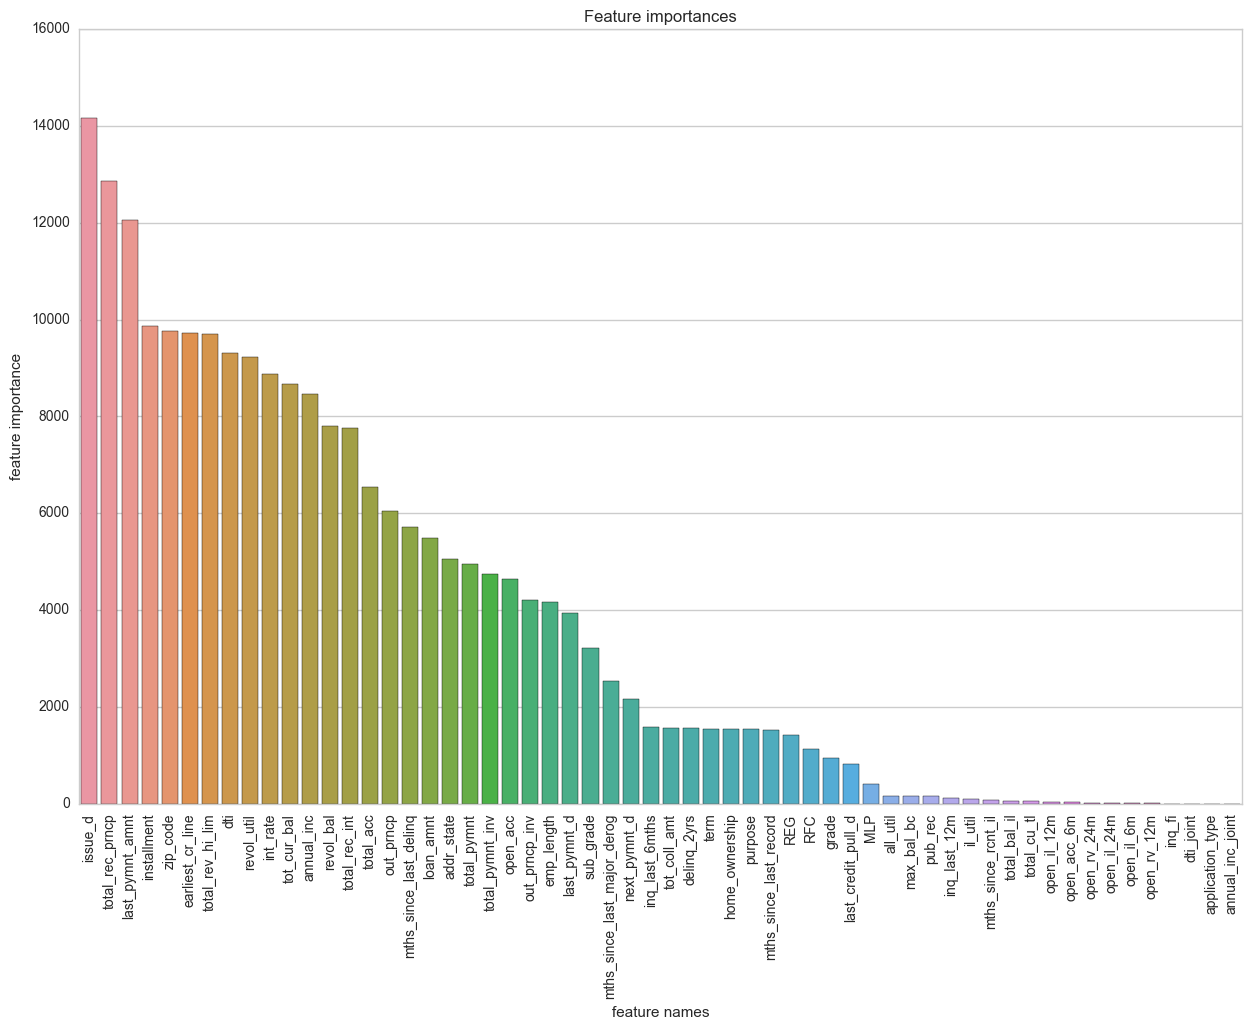

In [11]:
# Plot feature importances

import seaborn as sns

sns.set(style='whitegrid')

f, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=featssorted['name'], y=featssorted['feature importance'])
ax.set(xlabel='feature names', ylabel='feature importance')
ax.set_title('Feature importances')
for item in ax.get_xticklabels():
    item.set_rotation(90)

## Final model - sensitivity test

In [12]:
# Remove output from previous optimised models that were added as features to the dataset

trn_xv2 = trn_x.drop(['RFC','REG', 'MLP'],axis=1)

val_xv2 = val_x.drop(['RFC','REG', 'MLP'],axis=1)


In [13]:
# run XGBoost on reduced train & test sets

train_datav2 = lgb.Dataset(trn_xv2, trn_y) 
test_datav2 = lgb.Dataset(val_xv2,val_y, reference=train_datav2) 

In [14]:

lgb.cv(param, train_datav2, num_round, nfold=5) # crossvalidates with 5 folds for selection
bstv2 = lgb.train(param, train_datav2, num_round, valid_sets=[test_datav2] )

[1]	valid_0's auc: 0.970343
[2]	valid_0's auc: 0.974497
[3]	valid_0's auc: 0.974036
[4]	valid_0's auc: 0.974419
[5]	valid_0's auc: 0.975096
[6]	valid_0's auc: 0.974857
[7]	valid_0's auc: 0.975107
[8]	valid_0's auc: 0.974755
[9]	valid_0's auc: 0.97477
[10]	valid_0's auc: 0.974894
[11]	valid_0's auc: 0.975036
[12]	valid_0's auc: 0.975071
[13]	valid_0's auc: 0.975294
[14]	valid_0's auc: 0.975353
[15]	valid_0's auc: 0.975502
[16]	valid_0's auc: 0.975582
[17]	valid_0's auc: 0.975664
[18]	valid_0's auc: 0.97685
[19]	valid_0's auc: 0.976725
[20]	valid_0's auc: 0.97778
[21]	valid_0's auc: 0.97774
[22]	valid_0's auc: 0.977613
[23]	valid_0's auc: 0.977658
[24]	valid_0's auc: 0.97762
[25]	valid_0's auc: 0.977556
[26]	valid_0's auc: 0.977525
[27]	valid_0's auc: 0.977836
[28]	valid_0's auc: 0.977685
[29]	valid_0's auc: 0.977582
[30]	valid_0's auc: 0.978074
[31]	valid_0's auc: 0.978077
[32]	valid_0's auc: 0.978447
[33]	valid_0's auc: 0.978388
[34]	valid_0's auc: 0.978365
[35]	valid_0's auc: 0.978395